# Predicting funding of DonorsChoose.org teacher proposals


### Note that much of the code has been moved to `src` 

## Exploratory Data Analysis
- None of the correlations of numeric features with the outcome were >10%, suggesting that there are no magic bullets for this problem (and also that there's probably not feature leakage) 
- There are intuitive patterns for most of the categorical features (e.g. impoverished schools are more likely to receive funding). For some of the higher cardinality features (e.g. primary subject area), there are clear patterns but care must be taken to avoid overfitting for the rare categories. 
- The first few years of data have many fewer proposals but they were funded at a higher rate. 
- There are many more projects proposed in the fall (beginning of school year), and they're more likely to be funded

## Questions for the Project Partner
- Primarily, I would get a more clear idea of their goal with this project. Are they interested in predicting future project success (in which case the time series validation structure is key, and the evaluation metric should be accuracy)? Are they interested in helping teachers craft more successful project proposals (in which case it's key to use a model that outputs class probabilities, and AUC should be the evalution metric). If the latter, then it's very important to do natural lanaguage processing of the text features, as they are likely targets to maximize project success (ie, teachers cannot change the school's poverty level, but they can change the tone of their essay and use key phrases). 

## Modelling
### I: Feature Engineering (in `src`)
In addition to calculating price per student reached, I remapping rare categories for some features to "OTHER". Given more time, I would make this feature engineering part of the sklearn transformer pipeline to expose feature engineering hyperparameters (e.g. threshold at which a category is mapped to "OTHER") to model optimization. 
### II: Define testing and training set
Assuming the goal is predicting future data, I set aside 2013 data as the final test set, and use all preceding data to train the model. For model cross-validation, I will use the sklearn `TimeSeriesSplit` so that the cross-validation data structure resembles the test data structure

### III: Build and evaluate untuned Random Forest model 
As suspected, the model exhibits overfitting, but the performance is adequate to do some model evaluation. 
- Price is by far the most important feature
Using SHAP values, you can see magnitude, directionality, and frequency of feature importance, as well as detect potential interactions between features. For example, I see that 
    - As expected, price is the dominant feature, and shows a fairly linear response without obvious interaction
    - Two dichotomous features, `teacher_teach_for_america` and `eligible_double_your_impact_match` have similar magnitudes, but since the latter has a much higher frequency of positive cases, it has a much larger feature importance

### IV: Build, optimize, and evaluate Gradient Boosted model 
I use the `XGBClassifier` with early stopping. The early stopping evaluation set is the 2012 data (which is held out from model training). I tune some key model hyperparameters using `GridSearch` optimization of a limited parameter space - the threshold for the feature selection and the xgboost hyperparameters of `max_depth`, `min_child_weight`, and `gamma`. Because early stopping already mitigates overfitting, the range of validation scores is fairly small for this parameter space (around 74-76% accuracy). The model still exhibits some overfitting, but achieves a decent validation accuracy of >76%. 
<br> **Final model evaluation** I use the 2013 test data to evaluate the tuned model. It achieves a 62% accuracy, which isn't very impressive. I also calculated the AUC value (even though my model was fit using accuracy as the evaluation metric), which is 0.65. This matches the top 20 of the Kaggle leaderboard (though of course the test set was different). 

### Next steps
- **Feature Engineering**
        - Add the feature engineering (remapping of rare categories) to the sklearn pipeline to expose parameters to optimization
        - Natural Language Processing of text features (e.g. proposal essays). In my other notebooks, I have played with using CountVectorizer and `nltk`'s Vader sentiment analyzer. There's some promise but certainly not a silver bullet. 
        - Use some of the sparse features (e.g. schoolid, teacherid) 
- **More algorithms** Explore non-tree based learning algorithms (esp SVM), and possibly stacking
- **Feature Selection** - Try RFECV rather than SelectFromModel (more accurate but slower)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from src.data import load_data
from src.visualization import plot_continuous_var, plot_categorical_var, plot_var_timeseries
from src.visualization import plot_learning_curve, plot_feature_importances
from src.utils import pipeline_cv_score

# # Machine Learning 
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, TimeSeriesSplit 
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

# Interpretation of model results
from pdpbox import pdp, get_dataset, info_plots
import shap

In [3]:
df = load_data()

In [4]:
df.head()

,projectid,title,short_description,need_statement,essay,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,...,eligible_almost_home_match,date_posted,fully_funded,price_per_student,date,month,year,state_mapped,city_mapped,primary_focus_subject_mapped
0,ffffc4f85b60efc5b52347df489d0238,iMath,It is imperative that teachers bring technolog...,My students need four iPods.,I am a fourth year fifth grade math teacher. T...,c24011b20fc161ed02248e85beb59a90,301c9bf0a45d159d162b65a93fddd74e,4.502130e+11,34.361999,-80.063582,...,0,2009-10-11,0,9.530333,2009-10-11,10,2009,SC,OTHER,Mathematics
1,ffffac55ee02a49d1abc87ba6fc61135,Recording Rockin' Readers,Can you imagine having to translate everything...,My students need a camcorder.,Can you imagine having to translate everything...,947066d0af47e0566f334566553dd6a6,103ed937d8d84fdffe8b87a4811f00bf,1.301230e+11,33.514296,-84.345336,...,0,2011-06-11,1,30.505000,2011-06-11,6,2011,GA,OTHER,Special Needs
2,ffff97ed93720407d70a2787475932b0,Kindergarten In Need of Important Materials!,It takes a special person to donate to a group...,My students need 17 assorted classroom materia...,Hi. I teach a wonderful group of 4-5 year old ...,462270f5d5c212162fcab11afa2623cb,9943fdb43ab5f2b53f27e961caf9e90a,3.600153e+11,40.631962,-73.923897,...,0,2010-09-11,1,20.706400,2010-09-11,9,2010,NY,Brooklyn,Early Development
3,ffff418bb42fad24347527ad96100f81,Whistle While We Work!,"By using the cross curricular games requested,...",My students need grade level appropriate games...,All work and no play makes school a dull place...,e885fb002a1d0d39aaed9d21a7683549,6c6ea0558a03d113856e828ca7706092,4.827030e+11,30.389966,-97.843495,...,0,2009-04-03,0,48.710500,2009-04-03,4,2009,TX,OTHER,Literature & Writing
4,ffff2d9c769c8fb5335e949c615425eb,Too Close for Comfort,Have you ever had to crowd around an iPad scre...,My students need another iPad to experience te...,Have you ever had to crowd around an iPad scre...,485784e52a4c85ea6783285d09d8aea4,f8e49225a821cc04e1176303e55d89ec,1.602640e+11,42.820593,-112.409161,...,0,2013-03-03,1,27.282000,2013-03-03,3,2013,OTHER,OTHER,Mathematics


# Exploratory  Data Analysis (very expedited)

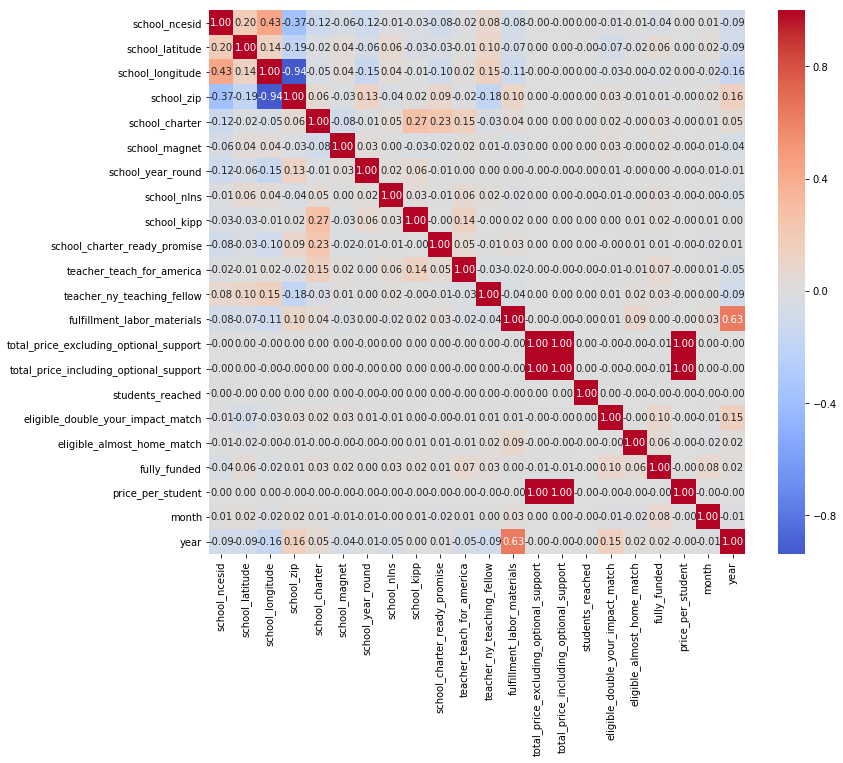

In [5]:
cols = df.select_dtypes(exclude='O').columns
corr = df[cols].corr()
plt.figure(figsize=[12,10])
g = sns.heatmap(corr,annot=True, fmt = ".2f", cmap = "coolwarm", center=0)

In [6]:
corr['fully_funded'].sort_values(ascending=False)

fully_funded                              1.000000
eligible_double_your_impact_match         0.097188
month                                     0.082796
teacher_teach_for_america                 0.069738
school_latitude                           0.061257
eligible_almost_home_match                0.055720
teacher_ny_teaching_fellow                0.032863
school_charter                            0.032069
school_nlns                               0.025048
year                                      0.022828
school_magnet                             0.018631
school_kipp                               0.018457
school_charter_ready_promise              0.013466
school_zip                                0.006217
fulfillment_labor_materials               0.004677
school_year_round                         0.001255
price_per_student                        -0.002130
students_reached                         -0.002840
total_price_including_optional_support   -0.009418
total_price_excluding_optional_

In [7]:
from src.visualization import plot_categorical_var

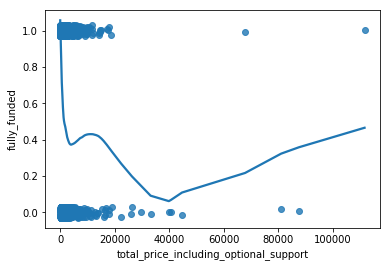

In [8]:
plot_continuous_var('total_price_including_optional_support', df)

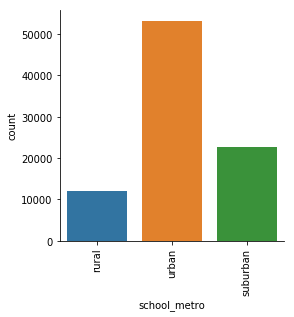

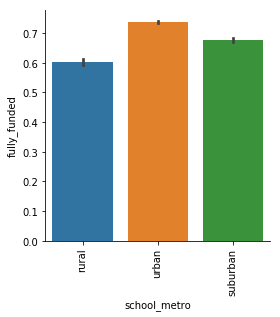

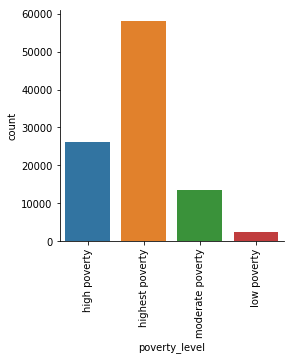

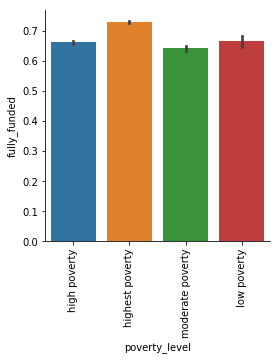

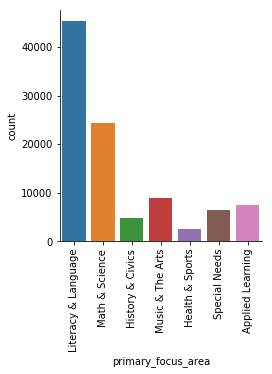

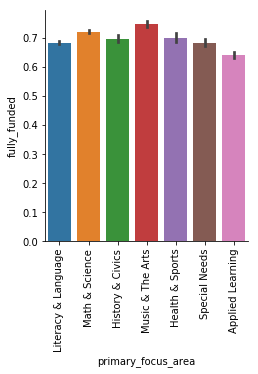

In [9]:
vars = ['school_metro', 'poverty_level', 'primary_focus_area']
for var in vars:
    plot_categorical_var(var, df)

# Temporal Trends
Interestingly, there seem to be seasonal fluctuations in funding patterns. Given the school year, it makes sense that many projects are posted in the fall, though it is unclear why those in the fall tend to have 10% higher success rate than those in the spring. 
The number of projects posted has drastically increased each year. Success rate dropped during the first few years, but since has remained somewhat constant since 2005.

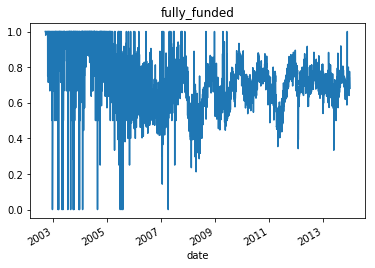

In [10]:
plot_var_timeseries('fully_funded', df)

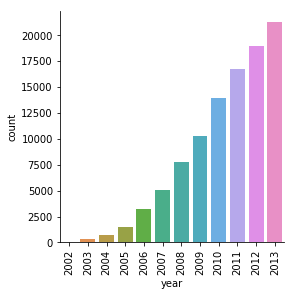

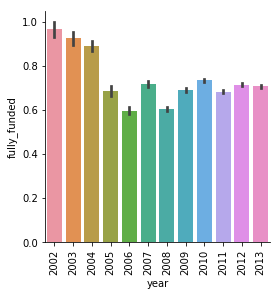

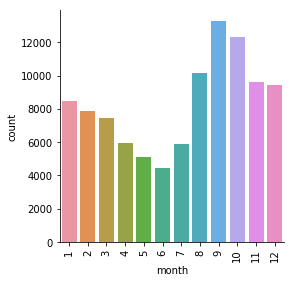

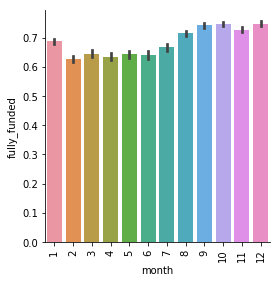

In [11]:
plot_categorical_var('year', df)
plot_categorical_var('month', df)

## Modelling II: Split data into training and testing
To simulate a real world problem, I'll use the last year of data (2013) as the test data, and only use old data to train the model (validating using a time-series approach). This may decrease accuracy but will increase generalizability

In [12]:
cols_to_keep = [
    'school_metro', 'school_charter', 'school_magnet', 
    'school_year_round', 'school_nlns', 'school_kipp',
    'school_charter_ready_promise', 'teacher_prefix',
    'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
    'primary_focus_area', 'resource_type',
   'poverty_level', 'grade_level', 'fulfillment_labor_materials',
   'total_price_excluding_optional_support', 'students_reached',
   'eligible_double_your_impact_match', 'eligible_almost_home_match',
   'price_per_student', 'month', 'year',
    'state_mapped', 'city_mapped', 'primary_focus_subject_mapped'
]

cols_to_drop = [
    'projectid',  # unique identifier
    'title', 'short_description', 'need_statement', 'essay',  # could do NLP later
    'teacher_acctid', 'schoolid', 'school_ncesid', 'school_district', 'school_county', 'school_zip' # could try using these identifiers later
    'date', 'date_posted',  # has already had month and year extracted
    'secondary_focus_subject', 'secondary_focus_area'  # high dimensionality, try later
    'school_state', 'school_city', 'primary_focus_subject' # were mapped to lower dimensionality features
    'total_price_including_optional_support', # correlated with other price feature, could do PCA or feature selection 
    'school_latitude', 'school_longitude',  # need a better way to handle location
]

# Make sure I didn't forget any columns
assert all([col in cols_to_keep + cols_to_drop] for col in df.columns)

In [13]:
from src.data import OUTCOME as outcome

df_test = df.query('year == 2013')
df_train = df.query('year < 2013')
X = df_train[cols_to_keep]
y = df_train[outcome]
X_test = df_test[cols_to_keep]
y_test = df_test[outcome]

# TEMP - subset for faster model development
X = X[:100_000]
y = y[:100_000]

In [14]:
# Use a time series split
tscv = TimeSeriesSplit(n_splits=5)

## Modelling III: Build and evaluate an untuned RandomForest model

In [15]:
num_cols = X.select_dtypes(['integer', 'float']).columns.tolist()
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler())
num_steps = [num_si_step] #num_ss_step - for now we won't use scaling, as it shouldn't matter for tree-based algorithms 
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]

cat_cols = X.select_dtypes('O').columns.tolist()
cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
# cat_si_step = ('si', SimpleImputer(strategy='most_frequent'))  # seems way slower
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, cat_cols)]

transformers = [('cat', cat_pipe, cat_cols),
                    ('num', num_pipe, num_cols)]
ct = ColumnTransformer(transformers=transformers)

# Parameters not tuned
classifier = RandomForestClassifier(max_depth=12, n_estimators=20, random_state=42) 
pipeline = Pipeline([('transformer', ct),
                     ('classifier', classifier)])


In [16]:
%%time
pipeline_cv_score(pipeline, X, y, tscv)

Cross Validation Score = 0.718 with std = 0.0017
Wall time: 8.6 s


Wall time: 8.24 s


<module 'matplotlib.pyplot' from 'c:\\users\\zrankin\\appdata\\local\\continuum\\miniconda3\\envs\\kaggle\\lib\\site-packages\\matplotlib\\pyplot.py'>

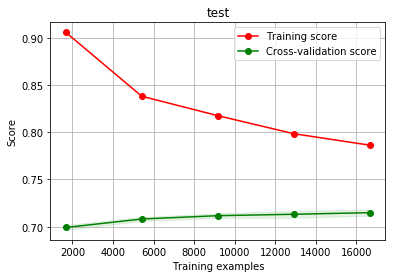

In [17]:
%%time
plot_learning_curve(pipeline, 'test', X, y, cv=tscv)

### For many model evaluation tools, we want the feature names, which are mangled during OneHotEncoding. Here, we convert the numpy array from the transformer pipeline to a pd.DataFrame with complete feature names 

In [18]:
def rename_features(feature_list, old, new):
    return [f.replace(old, new) for f in feature_list]
    
def rename_ohe_features(ohe_feature_list, column_names):
    """
    Utility function to add original feature names after sklearn OneHotEncoder
    e.g. if 'myfeature' is encoded, it gives ['x0_cat1', 'x0_cat2']
    rename_ohe_features(['x0_cat1', 'x0_cat2'], 'myfeature') 
    returns ['myfeature_cat1', 'myfeature_cat2']
    """
    for i, col in enumerate(column_names):
        ohe_feature_list = rename_features(ohe_feature_list, f'x{i}', col)
    return ohe_feature_list

In [19]:
X_transformed = ct.fit_transform(X)

In [20]:
# Get the feature names from pipeline
ohe_feature_list = list(ct.named_transformers_['cat'].named_steps['ohe'].get_feature_names())
cat_features = rename_ohe_features(ohe_feature_list, cat_cols)
cat_features

['school_metro_MISSING',
 'school_metro_rural',
 'school_metro_suburban',
 'school_metro_urban',
 'teacher_prefix_Dr.',
 'teacher_prefix_Mr.',
 'teacher_prefix_Mrs.',
 'teacher_prefix_Ms.',
 'primary_focus_area_Applied Learning',
 'primary_focus_area_Health & Sports',
 'primary_focus_area_History & Civics',
 'primary_focus_area_Literacy & Language',
 'primary_focus_area_Math & Science',
 'primary_focus_area_Music & The Arts',
 'primary_focus_area_Special Needs',
 'resource_type_Books',
 'resource_type_Other',
 'resource_type_Supplies',
 'resource_type_Technology',
 'resource_type_Trips',
 'resource_type_Visitors',
 'poverty_level_high poverty',
 'poverty_level_highest poverty',
 'poverty_level_low poverty',
 'poverty_level_moderate poverty',
 'grade_level_Grades 3-5',
 'grade_level_Grades 6-8',
 'grade_level_Grades 9-12',
 'grade_level_Grades PreK-2',
 'grade_level_MISSING',
 'state_mapped_AZ',
 'state_mapped_CA',
 'state_mapped_CO',
 'state_mapped_CT',
 'state_mapped_DC',
 'state_mapped_FL',
 'state_mapped_GA',
 'state_mapped_IL',
 'state_mapped_IN',
 'state_mapped_LA',
 'state_mapped_MA',
 'state_mapped_MD',
 'state_mapped_MI',
 'state_mapped_MO',
 'state_mapped_MS',
 'state_mapped_NC',
 'state_mapped_NJ',
 'state_mapped_NV',
 'state_mapped_NY',
 'state_mapped_OH',
 'state_mapped_OK',
 'state_mapped_OR',
 'state_mapped_OTHER',
 'state_mapped_PA',
 'state_mapped_SC',
 'state_mapped_TN',
 'state_mapped_TX',
 'state_mapped_UT',
 'state_mapped_VA',
 'state_mapped_WA',
 'state_mapped_WI',
 'city_mapped_Bronx',
 'city_mapped_Brooklyn',
 'city_mapped_Charlotte',
 'city_mapped_Chicago',
 'city_mapped_Houston',
 'city_mapped_Indianapolis',
 'city_mapped_Los Angeles',
 'city_mapped_New York',
 'city_mapped_OTHER',
 'city_mapped_Philadelphia',
 'city_mapped_San Francisco',
 'city_mapped_Washington',
 'primary_focus_subject_mapped_Applied Sciences',
 'primary_focus_subject_mapped_Character Education',
 'primary_focus_subject_mapped_ESL',
 'primary_focus_subject_mapped_Early Development',
 'primary_focus_subject_mapped_Environmental Science',
 'primary_focus_subject_mapped_Gym & Fitness',
 'primary_focus_subject_mapped_Health & Life Science',
 'primary_focus_subject_mapped_History & Geography',
 'primary_focus_subject_mapped_Literacy',
 'primary_focus_subject_mapped_Literature & Writing',
 'primary_focus_subject_mapped_Mathematics',
 'primary_focus_subject_mapped_Music',
 'primary_focus_subject_mapped_OTHER',
 'primary_focus_subject_mapped_Other',
 'primary_focus_subject_mapped_Performing Arts',
 'primary_focus_subject_mapped_Social Sciences',
 'primary_focus_subject_mapped_Special Needs',
 'primary_focus_subject_mapped_Visual Arts']

In [21]:
# Get a pd.DataFrame with the feature names 
df_transformed = pd.DataFrame(X_transformed, columns=cat_features + num_cols)
df_transformed.shape

(100000, 107)

In [22]:
df_transformed.head()

,school_metro_MISSING,school_metro_rural,school_metro_suburban,school_metro_urban,teacher_prefix_Dr.,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,...,teacher_teach_for_america,teacher_ny_teaching_fellow,fulfillment_labor_materials,total_price_excluding_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,price_per_student,month,year
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,9.0,703.34,90.0,0.0,0.0,9.530333,10.0,2009.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,35.0,207.43,8.0,0.0,0.0,30.505000,6.0,2011.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,35.0,440.01,25.0,1.0,0.0,20.706400,9.0,2010.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,17.0,798.85,20.0,0.0,0.0,48.710500,4.0,2009.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,30.0,797.30,11.0,0.0,0.0,85.272727,12.0,2012.0


In [23]:
classifier.fit(df_transformed, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

<Figure size 576x1080 with 0 Axes>

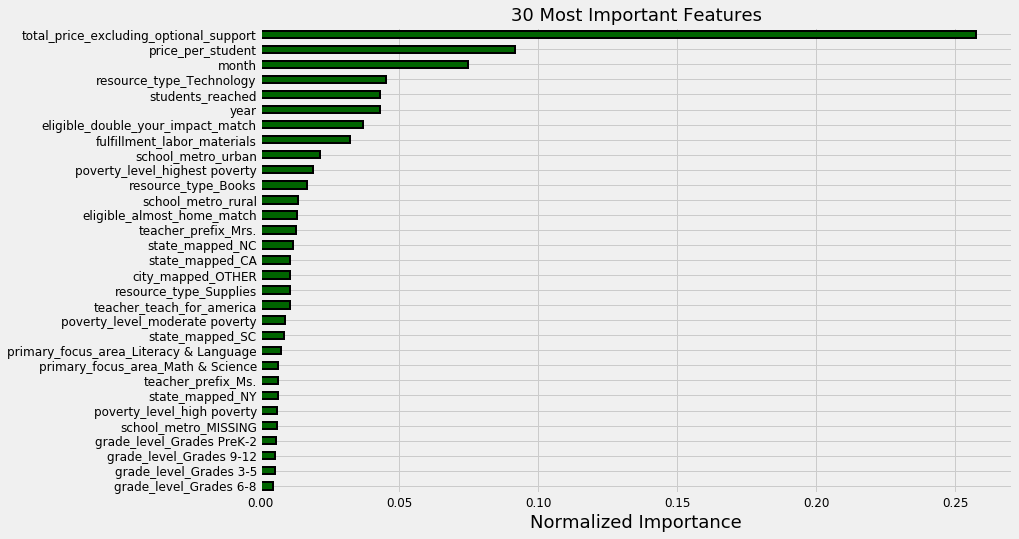

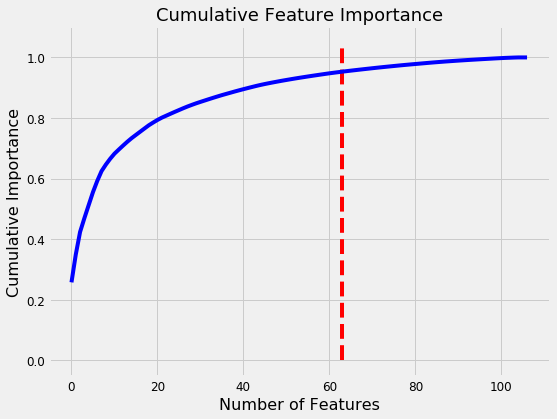

63 features required for 95% of cumulative importance.


In [24]:
# Feature importances
features = df_transformed.columns
feature_importances = pd.DataFrame({'feature': features, 'importance': classifier.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plot_feature_importances(feature_importances, n=30, threshold=0.95)

### I find SHAP (SHapley Additive exPlanations) value plots very useful for model insights, providing a more detailed intuition than feature importances
- At the individual level (first javascript plot that doesn't render on github), you can evaluate how each feature value impacts the model's prediction. 
- At the aggregate level, you can see magnitude, directionality, and frequency of feature importance, as well as detect potential interactions between features. For example, I see that 
    - As expected, price is the dominant feature, and shows a fairly linear response without obvious interaction
    - Two dichotomous features, `teacher_teach_for_america` and `eligible_double_your_impact_match` have similar magnitudes, but since the latter has a much higher frequency of positive cases, it has a much larger feature importance

In [25]:
row_to_show = 1
data_for_prediction = df_transformed.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
# Create object that can calculate shap values
explainer = shap.TreeExplainer(classifier)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

classifier.predict(data_for_prediction_array)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

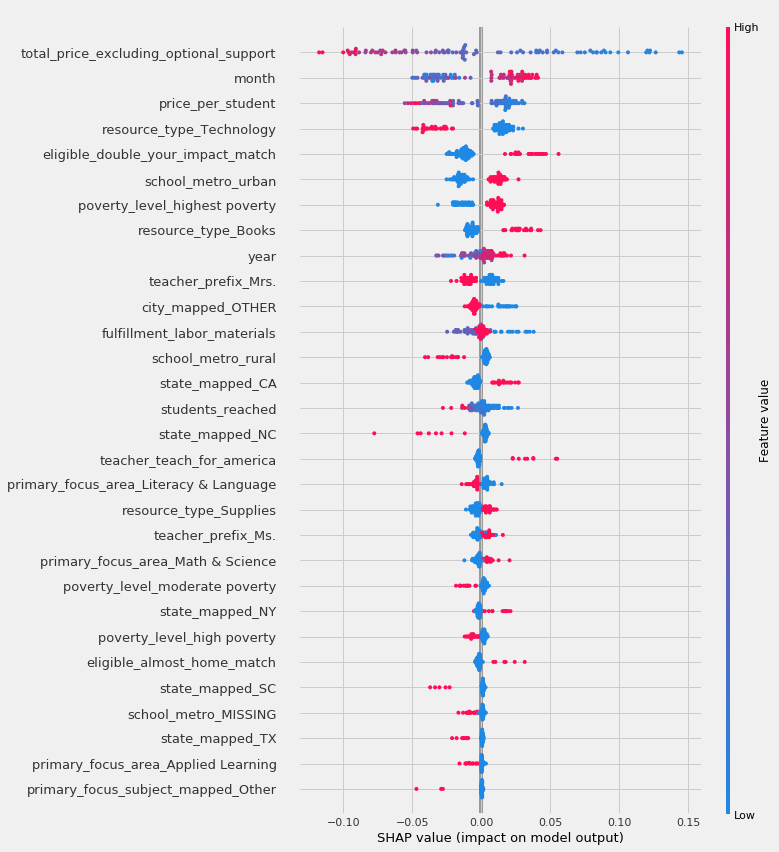

In [26]:
df_subset = df_transformed.sample(100, random_state=42)
shap_values = explainer.shap_values(df_subset)
shap.summary_plot(shap_values[1], df_subset, max_display=30)

### Partial Dependence plot
The pattern of the partial dependence plot of month shows a similar pattern to the bivariate analysis in the exploratory data analysis section. This is a good indication for our model specification, and doesn't particularly merit OneHotEncoding month (we could always try though)

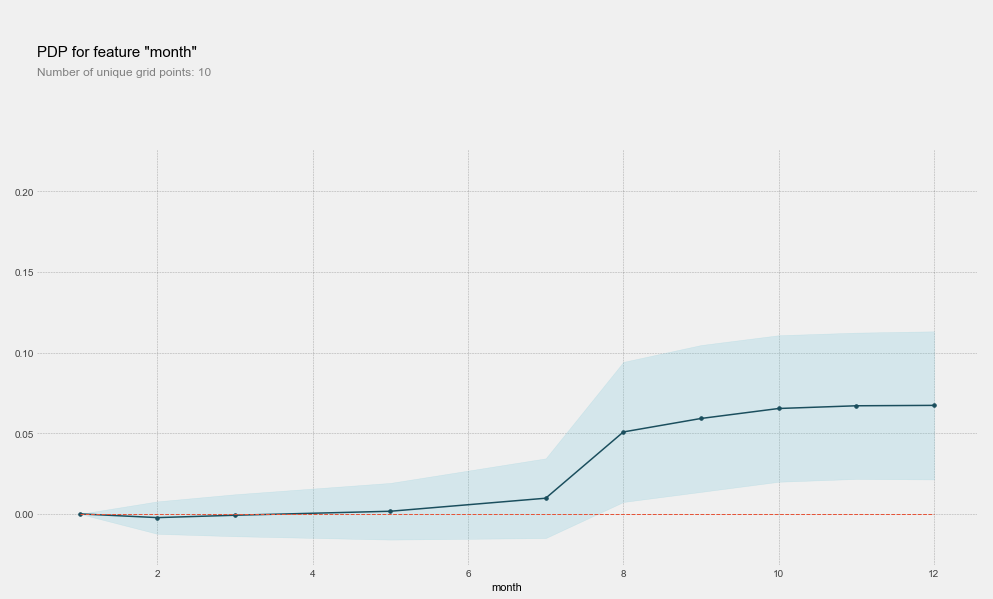

In [27]:
pdp_feature = pdp.pdp_isolate(model=classifier, dataset=df_transformed, model_features=df_transformed.columns.tolist(), feature='month')
pdp.pdp_plot(pdp_feature, 'month')
plt.show()

## Modelling IV: XGBoost with early stopping
Let's use a more complex algorithm, then compare results to the RandomForest. We'll later tune the hyperparameters. We will add a feature selection algorithm in the pipeline as another mechanism to limit overfitting. 

In [28]:
# First, set aside the 2012 data as the eval_set for early_stopping
idx_2012 = X.loc[X.year == 2012].index
X_train = X.drop(index=idx_2012)
X_val = X.loc[idx_2012]
y_train = y.drop(index=idx_2012)
y_val = y.loc[idx_2012]

# If you wanted to use a naive split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

eval_set = [(X_val, y_val)]

In [29]:
classifier = XGBClassifier(max_depth=3, eval_set=eval_set, early_stopping_rounds=10, n_estimators=200, random_state=42, n_jobs=4)

selection_classifier = ExtraTreesClassifier(max_depth=12, n_estimators=50, random_state=42)  # Note - hasn't been tuned
pipeline = Pipeline([('transformer', ct),
                     ('selection', SelectFromModel(selection_classifier, threshold=None)),
                     ('classifier', classifier)])

In [38]:
%%time
pipeline_cv_score(pipeline, X_train, y_train, tscv)

Cross Validation Score = 0.7366 with std = 0.0038
Wall time: 23.1 s


### GridSearch hyperparameter optimization for XGBoost, then select best model and score on test set (2013 data)
**Note** As this is time-consuming, I'll only vary a few parameters.

In [31]:
%%time
param_grid = {'selection__threshold': [None, '0.25*mean', '0.5*mean'],
              'classifier__gamma': [0, 0.1, 0.2],
              'classifier__subsample': [0.8],  # could be tuned later 
              'classifier__colsample_bytree': [0.8],  # could be tuned later 
              'classifier__min_child_weight': [1, 3, 5],
              'classifier__max_depth': [3, 6, 9]}

gridsearch = GridSearchCV(pipeline, param_grid=param_grid, cv = tscv, n_jobs=-1)
gridsearch.fit(X_train, y_train)

Wall time: 1h 8min 21s


In [32]:
grid_cols = ['mean_test_score', 'std_test_score', 'mean_fit_time'] + [key for key in gridsearch.cv_results_.keys() if 'param' in key]
df_grid = pd.DataFrame(gridsearch.cv_results_).sort_values('mean_test_score', ascending=False)[grid_cols]
df_grid.head()

,mean_test_score,std_test_score,mean_fit_time,param_classifier__colsample_bytree,param_classifier__gamma,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__subsample,param_selection__threshold,params
37,0.747485,0.005549,45.797031,0.8,0.1,6,1,0.8,0.25*mean,"{'classifier__colsample_bytree': 0.8, 'classif..."
10,0.747011,0.003556,47.118475,0.8,0,6,1,0.8,0.25*mean,"{'classifier__colsample_bytree': 0.8, 'classif..."
16,0.746727,0.004122,47.560851,0.8,0,6,5,0.8,0.25*mean,"{'classifier__colsample_bytree': 0.8, 'classif..."
64,0.746711,0.004158,46.181051,0.8,0.2,6,1,0.8,0.25*mean,"{'classifier__colsample_bytree': 0.8, 'classif..."
25,0.746332,0.004841,64.977847,0.8,0,9,5,0.8,0.25*mean,"{'classifier__colsample_bytree': 0.8, 'classif..."


### Because early stopping mitigates overfitting, the range of validation scores is fairly small for this parameter space (around 74-76% accuracy)

(array([ 4., 13.,  1.,  9., 17.,  2.,  7.,  8., 12.,  8.]),
 array([0.73530759, 0.73652531, 0.73774303, 0.73896075, 0.74017847,
        0.74139619, 0.74261391, 0.74383164, 0.74504936, 0.74626708,
        0.7474848 ]),
 <a list of 10 Patch objects>)

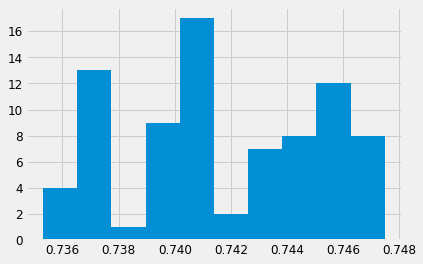

In [33]:
plt.hist(df_grid.mean_test_score)

In [34]:
final_model = gridsearch.best_estimator_
print(gridsearch.best_params_)

{'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.1, 'classifier__max_depth': 6, 'classifier__min_child_weight': 1, 'classifier__subsample': 0.8, 'selection__threshold': '0.25*mean'}


Wall time: 1min 10s


<module 'matplotlib.pyplot' from 'c:\\users\\zrankin\\appdata\\local\\continuum\\miniconda3\\envs\\kaggle\\lib\\site-packages\\matplotlib\\pyplot.py'>

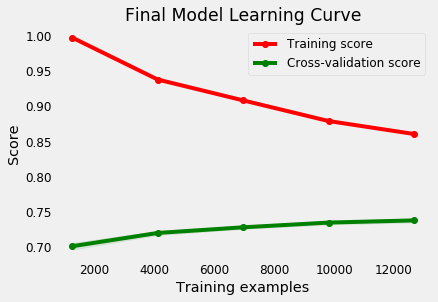

In [35]:
%%time
plot_learning_curve(final_model, 'Final Model Learning Curve', X_train, y_train, cv=tscv)

In [36]:
# Use all training data (including the 2012 validation set) to predict 2013 accuracy
final_model.fit(X, y)
(final_model.predict(X_test) == y_test).mean()

0.6353204547358161

In [37]:
# AUC score for final model (NOTE - the model was trained for accuracy, NOT AUC)
y_pred = final_model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.651594644588943

In [41]:
# Save final model
from sklearn.externals import joblib
joblib.dump(final_model, '../models/final_model.pkl')

['../models/final_model.pkl']